In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os
import seaborn as sns
sns.set_theme(style='darkgrid')
matplotlib.rcParams.update({'font.size':16})

%matplotlib inline

### Part 4. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms
from PIL import Image

device = torch.device("cuda:0")

In [4]:
# make a custom datasets for our task
import glob
train_folder = 'data/train/'
test_folder = 'data/test/'

class TrainDataset(Dataset):
    def __init__(self, folder='data/train/', transform=None):
        self.transform = transform
        self.folder = folder
        self.folder_numbers = sorted(list(map(int, [f[11:] for f in glob.glob(train_folder + '*')])))
        self.paths = []
        for i in self.folder_numbers:
            self.paths += [f for f in glob.glob(folder + f'{i}/' + '*')]

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        img = Image.open(self.paths[index]).convert('RGB')
        
        y = int(self.paths[index].split('/')[-1].split('\\')[0])

        if self.transform:
            img = self.transform(img)
        
        return img, y

class TestDataset(Dataset):
    def __init__(self, folder='data/test/', transform=None):
        self.transform = transform
        self.folder = folder
        self.paths = [f for f in glob.glob(folder + '*')]
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        
        img_id = self.paths[index].split('\\')[-1]
        
        img = Image.open(self.paths[index]).convert('RGB')

        if self.transform:
            img = self.transform(img)
        
        return img, img_id

In [5]:
# make datasets for train and test
train_dataset = TrainDataset(transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.ColorJitter(brightness=0.1, contrast=0.1,
                                                  saturation=0.1),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomAffine(degrees=0, 
                                        translate=(0.07, 0.07))])
                            )

test_dataset = TestDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
                          )

In [6]:
# create DataLoaders for train, val and test
batch_size = 64

data_size = len(train_dataset)
validation_fraction = 0.2

val_split = int(np.floor(validation_fraction * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

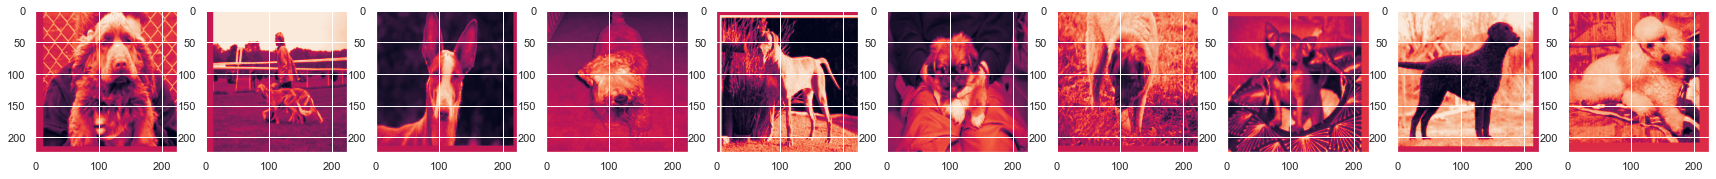

In [7]:
# look what we get
fig, ax = plt.subplots(ncols=10, nrows=1, figsize = (30, 8))

for img, label in train_loader:
    for i in range(0, 50, 5):
        ax[i//5].imshow(img[i][0])
    break

In [8]:
# decent customizable scheduler once picked up from kaggle
import math
class CosineDecayWithWarmUpScheduler(object):
    def __init__(self, optimizer, step_per_epoch=1, init_warmup_lr=1e-6,
                 warm_up_steps=0, max_lr=1e-3, min_lr=5e-5,
                 num_step_down=10, num_step_up=0,
                 T_mul=1, max_lr_decay='Exp',
                 gamma=0.5, min_lr_decay='Exp', alpha=0.2):
        self.optimizer = optimizer
        self.step_per_epoch = step_per_epoch
        if warm_up_steps != 0:
            self.warm_up = True
        else:
            self.warm_up = False
        self.init_warmup_lr = init_warmup_lr
        self.warm_up_steps = warm_up_steps
        self.max_lr = max_lr
        if min_lr == 0:
            self.min_lr = 0.1 * max_lr
            self.alpha = 0.1
        else:
            self.min_lr = min_lr
        self.num_step_down = num_step_down
        if num_step_up == None:
            self.num_step_up = num_step_down
        else:
            self.num_step_up = num_step_up
        self.T_mul = T_mul
        if max_lr_decay == None:
            self.gamma = 1
        elif max_lr_decay == 'Half':
            self.gamma = 0.5
        elif max_lr_decay == 'Exp':
            self.gamma = gamma

        if min_lr_decay == None:
            self.alpha = 1
        elif min_lr_decay == 'Half':
            self.alpha = 0.5
        elif min_lr_decay == 'Exp':
            self.alpha = alpha

        self.num_T = 0
        self.iters = 0
        self.lr_list = []

    def update_cycle(self, lr):
        old_min_lr = self.min_lr
        if lr == self.max_lr or (self.num_step_up == 0 and lr == self.min_lr):
            if self.num_T == 0:
                self.warm_up = False
                self.min_lr /= self.alpha
            self.iters = 0
            self.num_T += 1
            self.min_lr *= self.alpha

        if lr == old_min_lr and self.max_lr * self.gamma >= self.min_lr:
            self.max_lr *= self.gamma

    def step(self):
        self.iters += 1
        if self.warm_up:
            lr = self.init_warmup_lr + (self.max_lr - self.init_warmup_lr) / self.warm_up_steps * self.iters
        else:
            T_cur = self.T_mul ** self.num_T
            if self.iters <= self.num_step_down * T_cur:
                lr = self.min_lr + (self.max_lr - self.min_lr) * (
                            1 + math.cos(math.pi * self.iters / (self.num_step_down * T_cur))) / 2
                if lr < self.min_lr:
                    lr = self.min_lr
            elif self.iters > self.num_step_down * T_cur:
                lr = self.min_lr + (self.max_lr - self.min_lr) / (self.num_step_up * T_cur) * (
                            self.iters - self.num_step_down * T_cur)
                if lr > self.max_lr:
                    lr = self.max_lr

        self.update_cycle(lr)

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            self.lr_list.append(lr)

In [9]:
# usual train, estimating and visualizing functions
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs,
                scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        for i_step, (x, y) in enumerate(train_loader):
            x, y = x.cuda(), y.cuda()
            
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad(set_to_none=True)
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(float(val_accuracy))
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        if scheduler is not None:
            scheduler.step()
        print('-' * 75)
        
    return loss_history, train_history, val_history

        
def compute_accuracy(model, loader):

    model.eval() # Evaluation mode
    total_samples = 0
    correct_samples = 0
    for x, y in loader:
        x, y = x.cuda(), y.cuda()
        prediction = model(x)
        total_samples += y.shape[0]
        correct_samples += torch.sum(torch.argmax(prediction, dim=1) == y)
    
    accuracy = correct_samples / total_samples
    return accuracy


def plot_results(loss, train_accuracy, val_accuracy):
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10, 16))
    
    ax[0].plot(loss, lw=3, color=sns.color_palette()[0])

    ax[0].set_xlabel('epoch', fontsize=18)
    ax[0].set_ylabel('loss', fontsize=18)
    ax[0].set_title("Average loss on train", fontsize=20)
    
    ax[0].tick_params(axis='both', labelsize=16)
    
    ax[1].plot(train_accuracy, lw=3, color=sns.color_palette()[0],
              label='Train')
    ax[1].plot(val_accuracy, lw=3, color=sns.color_palette()[3],
              label='Validation')
    
    ax[1].set_title("Accuracy", fontsize=20)
    ax[1].set_xlabel('epoch', fontsize=18)
    ax[1].set_ylabel('accuracy', fontsize=18)
    ax[1].legend(shadow = True, fontsize=18, loc='upper left')
    ax[1].tick_params(axis='both', labelsize=16)
    
    plt.show()

### Let's try to find best pretrained model from torchvision and check if that'll be enough

#### EfficientNet_v2_s transfer learning

Epoch 1/40
Average loss: 3.115835, Train accuracy: 0.527298, Val accuracy: 0.831123
---------------------------------------------------------------------------
Epoch 2/40
Average loss: 1.788790, Train accuracy: 0.816501, Val accuracy: 0.859735
---------------------------------------------------------------------------
Epoch 3/40
Average loss: 1.078158, Train accuracy: 0.848073, Val accuracy: 0.866015
---------------------------------------------------------------------------
Epoch 4/40
Average loss: 0.779177, Train accuracy: 0.856794, Val accuracy: 0.879274
---------------------------------------------------------------------------
Epoch 5/40
Average loss: 0.633854, Train accuracy: 0.871795, Val accuracy: 0.884159
---------------------------------------------------------------------------
Epoch 6/40
Average loss: 0.555785, Train accuracy: 0.876679, Val accuracy: 0.888346
---------------------------------------------------------------------------
Epoch 7/40
Average loss: 0.520201, Train

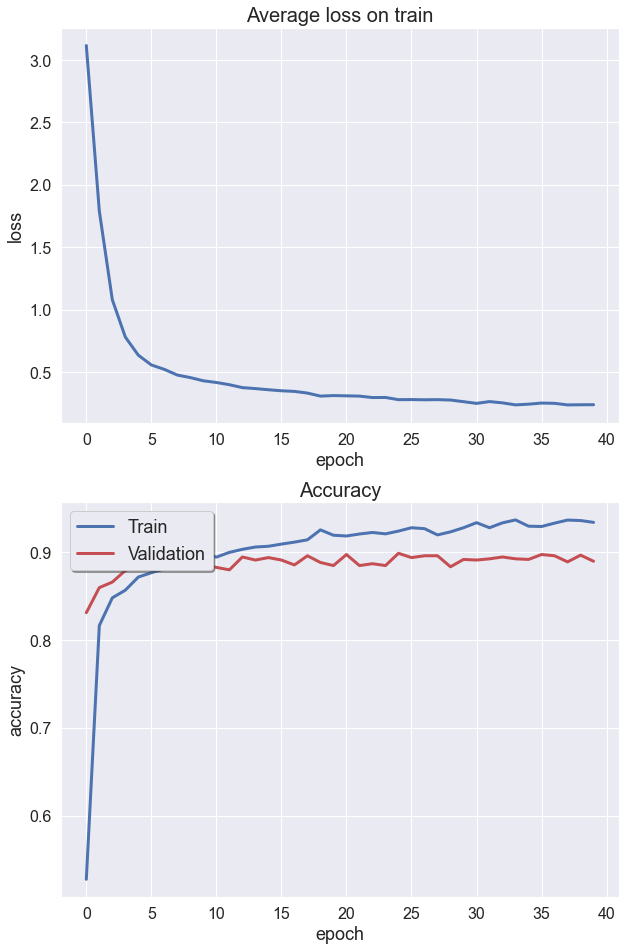

In [37]:
EfficientNet = models.efficientnet_v2_s(weights="EfficientNet_V2_S_Weights.IMAGENET1K_V1")

try:
    del model_transfer
except:
    pass
torch.cuda.empty_cache()

model_transfer = EfficientNet

for param in model_transfer.parameters():
    param.requires_grad = False
    
num_features = model_transfer.classifier[1].in_features
model_transfer.classifier[0] = nn.Dropout(p=0.25, inplace=True)
model_transfer.classifier[1] = nn.Linear(num_features, 50)

model_transfer = model_transfer.to(device)

parameters_transfer = model_transfer.classifier[1].parameters() 

loss_transfer = nn.CrossEntropyLoss()

optimizer_transfer = optim.Adam(parameters_transfer, betas=(0.9, 0.95),
                       lr=3e-4, weight_decay=1e-5)

scheduler_transfer = CosineDecayWithWarmUpScheduler(optimizer_transfer, 
                    max_lr=3e-4, min_lr=5e-6, num_step_down=20, 
                    num_step_up=0, gamma=0.5, alpha=0.3)


loss_history_transfer, train_history_transfer, val_history_transfer = train_model(model_transfer, train_loader, 
                                            val_loader, loss_transfer, 
                                            optimizer_transfer, 40)
plot_results(loss_history_transfer, train_history_transfer, val_history_transfer)

#### DenseNet201 transfer learning

Epoch 1/40
Average loss: 3.008245, Train accuracy: 0.431711, Val accuracy: 0.727146
---------------------------------------------------------------------------
Epoch 2/40
Average loss: 1.565998, Train accuracy: 0.833944, Val accuracy: 0.859037
---------------------------------------------------------------------------
Epoch 3/40
Average loss: 0.901069, Train accuracy: 0.891505, Val accuracy: 0.879972
---------------------------------------------------------------------------
Epoch 4/40
Average loss: 0.607740, Train accuracy: 0.914704, Val accuracy: 0.898814
---------------------------------------------------------------------------
Epoch 5/40
Average loss: 0.465409, Train accuracy: 0.925344, Val accuracy: 0.898814
---------------------------------------------------------------------------
Epoch 6/40
Average loss: 0.378482, Train accuracy: 0.934938, Val accuracy: 0.900907
---------------------------------------------------------------------------
Epoch 7/40
Average loss: 0.332747, Train

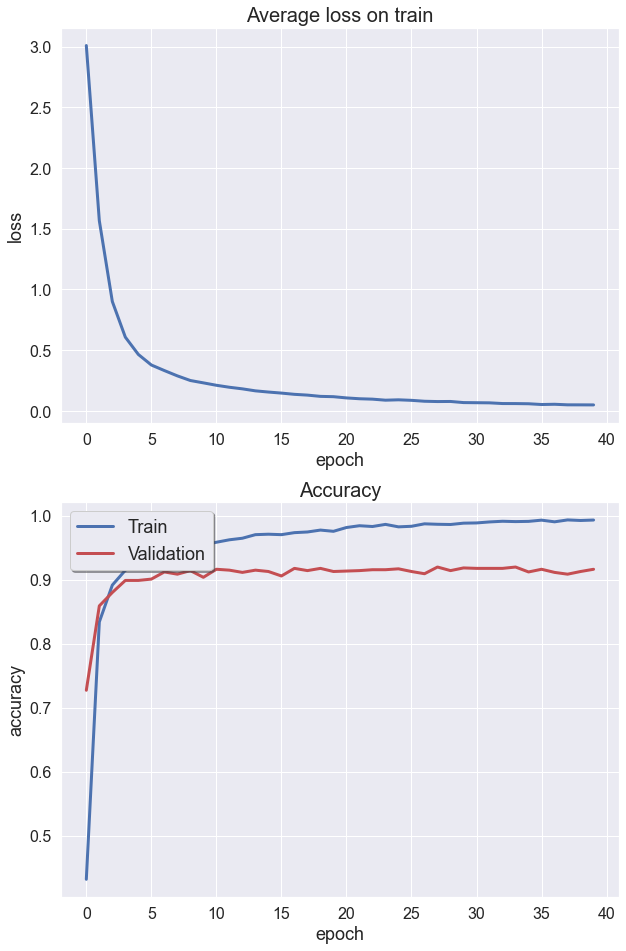

In [39]:
DenseNet = models.densenet201(weights="DenseNet201_Weights.IMAGENET1K_V1")

try:
    del dn_transfer
except:
    pass
torch.cuda.empty_cache()

dn_transfer = DenseNet

for param in dn_transfer.parameters():
    param.requires_grad = False
    
num_features = dn_transfer.classifier.in_features
dn_transfer.classifier = nn.Linear(num_features, 50)

dn_transfer = dn_transfer.to(device)

parameters_dn_transfer = dn_transfer.classifier.parameters() 

loss_dn_transfer = nn.CrossEntropyLoss()

optimizer_dn_transfer = optim.Adam(parameters_dn_transfer, betas=(0.9, 0.95),
                       lr=3e-4, weight_decay=1e-5)

scheduler_dn_transfer = CosineDecayWithWarmUpScheduler(optimizer_dn_transfer, 
                    max_lr=3e-4, min_lr=3e-6, num_step_down=20, 
                    num_step_up=0, gamma=0.5, alpha=0.3)


loss_history_dn_transfer, train_history_dn_transfer, val_history_dn_transfer = train_model(dn_transfer, train_loader, 
                                            val_loader, loss_dn_transfer, 
                                            optimizer_dn_transfer, 40)
plot_results(loss_history_dn_transfer, train_history_dn_transfer, val_history_dn_transfer)

#### ResNext50_32x4D transfer learning

Epoch 1/40
Average loss: 3.296299, Train accuracy: 0.414792, Val accuracy: 0.764829
---------------------------------------------------------------------------
Epoch 2/40
Average loss: 2.108790, Train accuracy: 0.847549, Val accuracy: 0.861828
---------------------------------------------------------------------------
Epoch 3/40
Average loss: 1.307396, Train accuracy: 0.905634, Val accuracy: 0.883461
---------------------------------------------------------------------------
Epoch 4/40
Average loss: 0.844340, Train accuracy: 0.928310, Val accuracy: 0.888346
---------------------------------------------------------------------------
Epoch 5/40
Average loss: 0.578493, Train accuracy: 0.936159, Val accuracy: 0.907188
---------------------------------------------------------------------------
Epoch 6/40
Average loss: 0.417947, Train accuracy: 0.949416, Val accuracy: 0.912073
---------------------------------------------------------------------------
Epoch 7/40
Average loss: 0.327311, Train

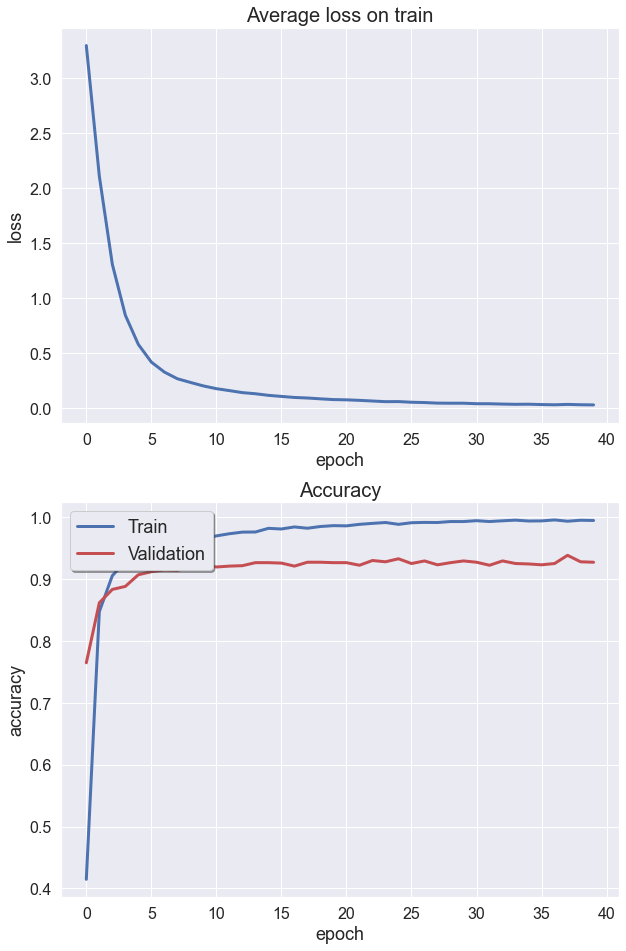

In [41]:
ResNext50 = models.resnext50_32x4d(weights="ResNeXt50_32X4D_Weights.IMAGENET1K_V2")

try:
    del RNxt_transfer
except:
    pass
torch.cuda.empty_cache()

RNxt_transfer = ResNext50

for param in RNxt_transfer.parameters():
    param.requires_grad = False
    
num_features = RNxt_transfer.fc.in_features
RNxt_transfer.fc = nn.Linear(num_features, 50)

RNxt_transfer = RNxt_transfer.to(device)

parameters_RNxt_transfer = RNxt_transfer.fc.parameters() 

loss_RNxt_transfer = nn.CrossEntropyLoss()

optimizer_RNxt_transfer = optim.Adam(parameters_RNxt_transfer, betas=(0.9, 0.95),
                       lr=3e-4, weight_decay=1e-5)

scheduler_RNxt_transfer = CosineDecayWithWarmUpScheduler(optimizer_RNxt_transfer, 
                    max_lr=3e-4, min_lr=3e-6, num_step_down=20, 
                    num_step_up=0, gamma=0.5, alpha=0.3)


loss_history_RNxt_transfer, train_history_RNxt_transfer, val_history_RNxt_transfer = train_model(RNxt_transfer, train_loader, 
                                            val_loader, loss_RNxt_transfer, 
                                            optimizer_RNxt_transfer, 40)
plot_results(loss_history_RNxt_transfer, train_history_RNxt_transfer, val_history_RNxt_transfer)

#### ResNet101 transfer learning

Epoch 1/40
Average loss: 3.294836, Train accuracy: 0.376766, Val accuracy: 0.734822
---------------------------------------------------------------------------
Epoch 2/40
Average loss: 2.127659, Train accuracy: 0.849817, Val accuracy: 0.865317
---------------------------------------------------------------------------
Epoch 3/40
Average loss: 1.321459, Train accuracy: 0.907553, Val accuracy: 0.898116
---------------------------------------------------------------------------
Epoch 4/40
Average loss: 0.834980, Train accuracy: 0.929705, Val accuracy: 0.915562
---------------------------------------------------------------------------
Epoch 5/40
Average loss: 0.565799, Train accuracy: 0.937903, Val accuracy: 0.908583
---------------------------------------------------------------------------
Epoch 6/40
Average loss: 0.405901, Train accuracy: 0.949416, Val accuracy: 0.926727
---------------------------------------------------------------------------
Epoch 7/40
Average loss: 0.316646, Train

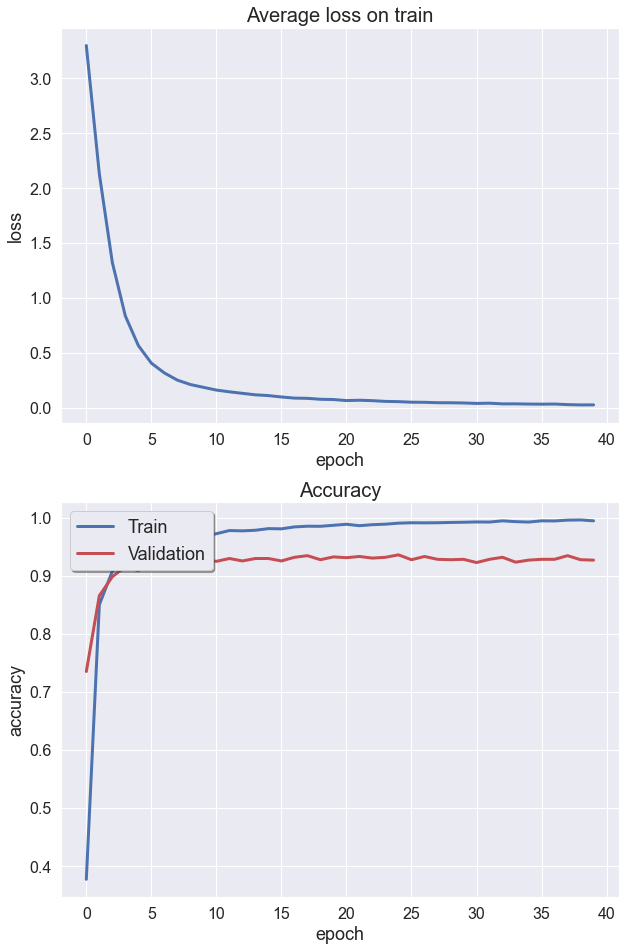

In [11]:
ResNet101 = models.resnet101(weights="ResNet101_Weights.IMAGENET1K_V2")

try:
    del RN_transfer
except:
    pass
torch.cuda.empty_cache()

RN_transfer = ResNet101

for param in RN_transfer.parameters():
    param.requires_grad = False
    
num_features = RN_transfer.fc.in_features
RN_transfer.fc = nn.Linear(num_features, 50)

RN_transfer = RN_transfer.to(device)

parameters_RN_transfer = RN_transfer.fc.parameters() 

loss_RN_transfer = nn.CrossEntropyLoss()

optimizer_RN_transfer = optim.Adam(parameters_RN_transfer, betas=(0.9, 0.95),
                       lr=3e-4, weight_decay=1e-5)

scheduler_RN_transfer = CosineDecayWithWarmUpScheduler(optimizer_RN_transfer, 
                    max_lr=3e-4, min_lr=3e-6, num_step_down=20, 
                    num_step_up=0, gamma=0.5, alpha=0.3)


loss_history_RN_transfer, train_history_RN_transfer, val_history_RN_transfer = train_model(RN_transfer, train_loader, 
                                            val_loader, loss_RN_transfer, 
                                            optimizer_RN_transfer, 40)
plot_results(loss_history_RN_transfer, train_history_RN_transfer, val_history_RN_transfer)

#### ResNet152 transfer learning

Epoch 1/40
Average loss: 3.359946, Train accuracy: 0.377638, Val accuracy: 0.756455
---------------------------------------------------------------------------
Epoch 2/40
Average loss: 2.256574, Train accuracy: 0.865690, Val accuracy: 0.874389
---------------------------------------------------------------------------
Epoch 3/40
Average loss: 1.456196, Train accuracy: 0.926391, Val accuracy: 0.916260
---------------------------------------------------------------------------
Epoch 4/40
Average loss: 0.925676, Train accuracy: 0.944357, Val accuracy: 0.916957
---------------------------------------------------------------------------
Epoch 5/40
Average loss: 0.605411, Train accuracy: 0.956044, Val accuracy: 0.922540
---------------------------------------------------------------------------
Epoch 6/40
Average loss: 0.416524, Train accuracy: 0.960928, Val accuracy: 0.941382
---------------------------------------------------------------------------
Epoch 7/40
Average loss: 0.307302, Train

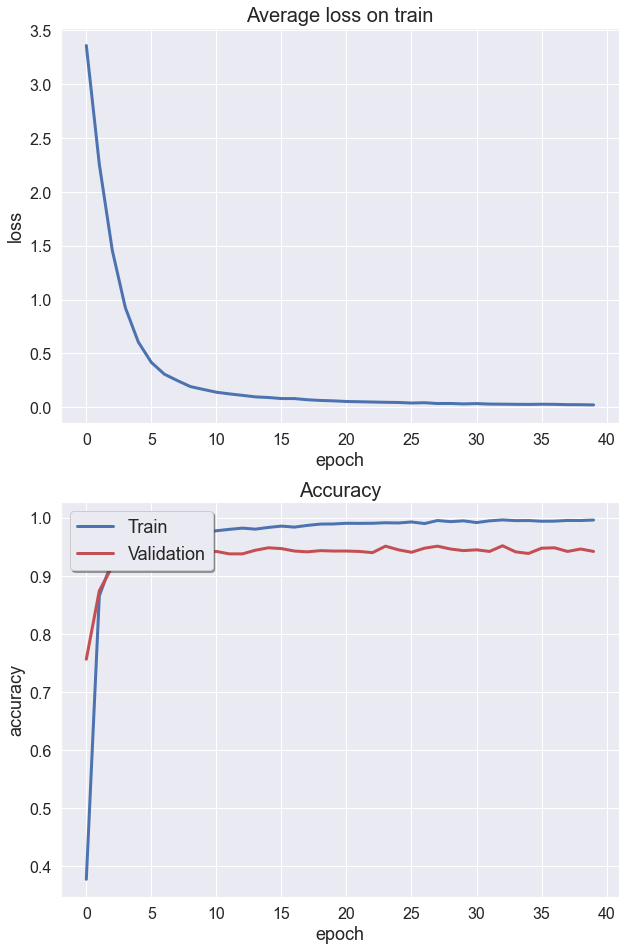

In [12]:
ResNet152 = models.resnet152(weights="ResNet152_Weights.IMAGENET1K_V2")

try:
    del RNl_transfer
except:
    pass
torch.cuda.empty_cache()

RNl_transfer = ResNet152

for param in RNl_transfer.parameters():
    param.requires_grad = False
    
num_features = RNl_transfer.fc.in_features
RNl_transfer.fc = nn.Linear(num_features, 50)

RNl_transfer = RNl_transfer.to(device)

parameters_RNl_transfer = RNl_transfer.fc.parameters() 

loss_RNl_transfer = nn.CrossEntropyLoss()

optimizer_RNl_transfer = optim.Adam(parameters_RNl_transfer, betas=(0.9, 0.95),
                       lr=3e-4, weight_decay=1e-5)

scheduler_RNl_transfer = CosineDecayWithWarmUpScheduler(optimizer_RNl_transfer, 
                    max_lr=3e-4, min_lr=3e-6, num_step_down=20, 
                    num_step_up=0, gamma=0.5, alpha=0.3)


loss_history_RNl_transfer, train_history_RNl_transfer, val_history_RNl_transfer = train_model(RNl_transfer, train_loader, 
                                            val_loader, loss_RNl_transfer, 
                                            optimizer_RNl_transfer, 40)
plot_results(loss_history_RNl_transfer, train_history_RNl_transfer, val_history_RNl_transfer)

#### RegNet_Y_8GF transfer learning

Epoch 1/40
Average loss: 3.335387, Train accuracy: 0.373452, Val accuracy: 0.728541
---------------------------------------------------------------------------
Epoch 2/40
Average loss: 2.274971, Train accuracy: 0.816501, Val accuracy: 0.828332
---------------------------------------------------------------------------
Epoch 3/40
Average loss: 1.541934, Train accuracy: 0.889412, Val accuracy: 0.866015
---------------------------------------------------------------------------
Epoch 4/40
Average loss: 1.053118, Train accuracy: 0.920809, Val accuracy: 0.886253
---------------------------------------------------------------------------
Epoch 5/40
Average loss: 0.738510, Train accuracy: 0.934240, Val accuracy: 0.898814
---------------------------------------------------------------------------
Epoch 6/40
Average loss: 0.540525, Train accuracy: 0.948892, Val accuracy: 0.914166
---------------------------------------------------------------------------
Epoch 7/40
Average loss: 0.413513, Train

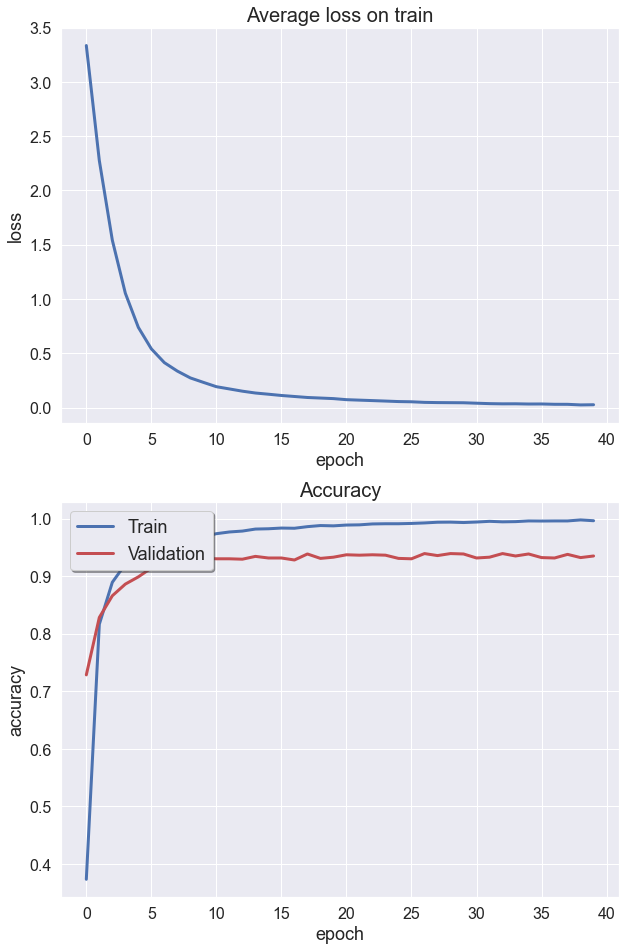

In [45]:
RegNetY = models.regnet_y_8gf(weights="RegNet_Y_8GF_Weights.IMAGENET1K_V2")

try:
    del RgNY_transfer
except:
    pass
torch.cuda.empty_cache()

RgNY_transfer = RegNetY

for param in RgNY_transfer.parameters():
    param.requires_grad = False
    
num_features = RgNY_transfer.fc.in_features
RgNY_transfer.fc = nn.Linear(num_features, 50)

RgNY_transfer = RgNY_transfer.to(device)

parameters_RgNY_transfer = RgNY_transfer.fc.parameters() 

loss_RgNY_transfer = nn.CrossEntropyLoss()

optimizer_RgNY_transfer = optim.Adam(parameters_RgNY_transfer, betas=(0.9, 0.95),
                       lr=3e-4, weight_decay=1e-5)

scheduler_RgNY_transfer = CosineDecayWithWarmUpScheduler(optimizer_RgNY_transfer, 
                    max_lr=3e-4, min_lr=3e-6, num_step_down=20, 
                    num_step_up=0, gamma=0.5, alpha=0.3)


loss_history_RgNY_transfer, train_history_RgNY_transfer, val_history_RgNY_transfer = train_model(RgNY_transfer, train_loader, 
                                            val_loader, loss_RgNY_transfer, 
                                            optimizer_RgNY_transfer, 40)
plot_results(loss_history_RgNY_transfer, train_history_RgNY_transfer, val_history_RgNY_transfer)

#### ConvNext_small transfer learning

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to C:\Users\Nikita/.cache\torch\hub\checkpoints\convnext_small-0c510722.pth


  0%|          | 0.00/192M [00:00<?, ?B/s]

Epoch 1/40
Average loss: 2.701675, Train accuracy: 0.768533, Val accuracy: 0.971389
---------------------------------------------------------------------------
Epoch 2/40
Average loss: 0.876133, Train accuracy: 0.977673, Val accuracy: 0.981856
---------------------------------------------------------------------------
Epoch 3/40
Average loss: 0.255385, Train accuracy: 0.983778, Val accuracy: 0.980461
---------------------------------------------------------------------------
Epoch 4/40
Average loss: 0.122311, Train accuracy: 0.984476, Val accuracy: 0.981856
---------------------------------------------------------------------------
Epoch 5/40
Average loss: 0.080801, Train accuracy: 0.986220, Val accuracy: 0.981158
---------------------------------------------------------------------------
Epoch 6/40
Average loss: 0.068703, Train accuracy: 0.985697, Val accuracy: 0.982554
---------------------------------------------------------------------------
Epoch 7/40
Average loss: 0.054959, Train

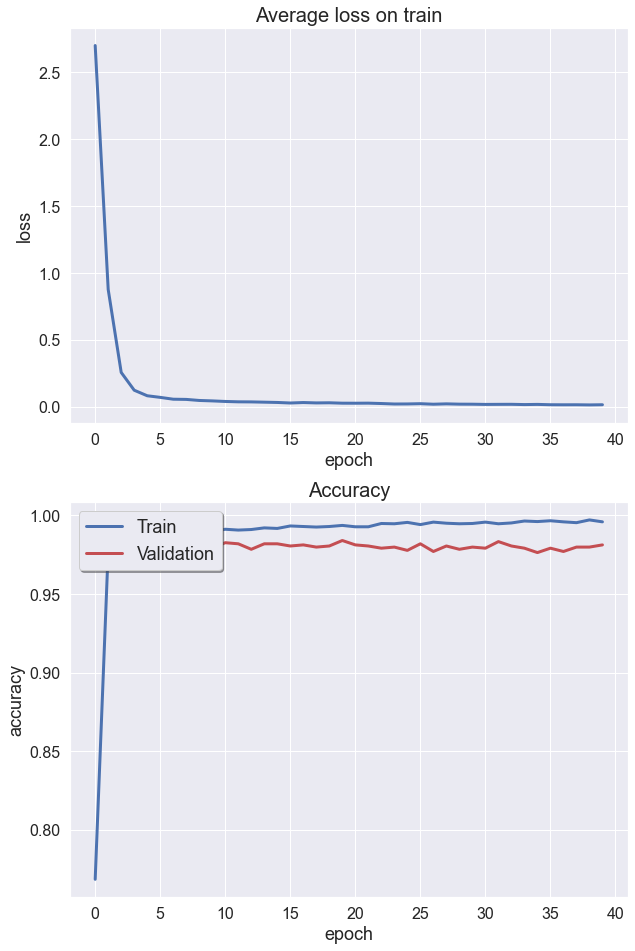

In [51]:
ConvNextS = models.convnext_small(weights="ConvNeXt_Small_Weights.IMAGENET1K_V1")

try:
    del CNs_transfer
except:
    pass
torch.cuda.empty_cache()

CNs_transfer = ConvNextS

for param in CNs_transfer.parameters():
    param.requires_grad = False
    
num_features = CNs_transfer.classifier[2].in_features
CNs_transfer.classifier[2] = nn.Linear(num_features, 50)

CNs_transfer = CNs_transfer.to(device)

parameters_CNs_transfer = CNs_transfer.classifier[2].parameters() 

loss_CNs_transfer = nn.CrossEntropyLoss()

optimizer_CNs_transfer = optim.Adam(parameters_CNs_transfer, betas=(0.9, 0.95),
                       lr=3e-4, weight_decay=1e-5)

scheduler_CNs_transfer = CosineDecayWithWarmUpScheduler(optimizer_CNs_transfer, 
                    max_lr=3e-4, min_lr=3e-6, num_step_down=20, 
                    num_step_up=0, gamma=0.5, alpha=0.3)


loss_history_CNs_transfer, train_history_CNs_transfer, val_history_CNs_transfer = train_model(CNs_transfer, train_loader, 
                                            val_loader, loss_CNs_transfer, 
                                            optimizer_CNs_transfer, 40)
plot_results(loss_history_CNs_transfer, train_history_CNs_transfer, val_history_CNs_transfer)

#### ConvNext_small tuning with dropout rate for last layer

Epoch 1/20
Average loss: 2.719101, Train accuracy: 0.748648, Val accuracy: 0.969993
---------------------------------------------------------------------------
Epoch 2/20
Average loss: 0.918742, Train accuracy: 0.978720, Val accuracy: 0.980461
---------------------------------------------------------------------------
Epoch 3/20
Average loss: 0.278386, Train accuracy: 0.984999, Val accuracy: 0.981856
---------------------------------------------------------------------------
Epoch 4/20
Average loss: 0.128350, Train accuracy: 0.985174, Val accuracy: 0.981856
---------------------------------------------------------------------------
Epoch 5/20
Average loss: 0.085886, Train accuracy: 0.985697, Val accuracy: 0.981158
---------------------------------------------------------------------------
Epoch 6/20
Average loss: 0.071982, Train accuracy: 0.985348, Val accuracy: 0.982554
---------------------------------------------------------------------------
Epoch 7/20
Average loss: 0.058322, Train

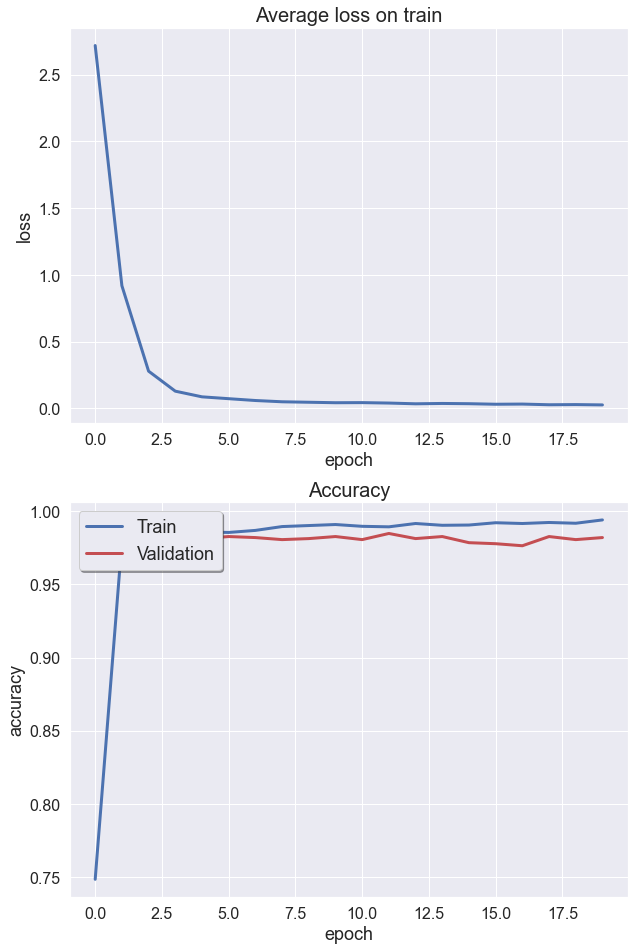

In [10]:
ConvNextS = models.convnext_small(weights="ConvNeXt_Small_Weights.IMAGENET1K_V1")

try:
    del CNs_dropout
except:
    pass
torch.cuda.empty_cache()

CNs_dropout = ConvNextS

for param in CNs_dropout.parameters():
    param.requires_grad = False
    
num_features = CNs_dropout.classifier[2].in_features
CNs_dropout.classifier[2] = nn.Sequential(
                            nn.Dropout(p=0.1),
                            nn.Linear(num_features, 50))

CNs_dropout = CNs_dropout.to(device)

parameters_CNs_dropout = CNs_dropout.classifier[2][1].parameters() 

loss_CNs_dropout = nn.CrossEntropyLoss()

optimizer_CNs_dropout = optim.Adam(parameters_CNs_dropout, betas=(0.9, 0.95),
                       lr=3e-4, weight_decay=1e-5)

scheduler_CNs_dropout = CosineDecayWithWarmUpScheduler(optimizer_CNs_dropout, 
                    max_lr=1e-4, min_lr=3e-6, num_step_down=20, 
                    num_step_up=0, gamma=0.7, alpha=0.1)




loss_history_CNs_dropout, train_history_CNs_dropout, val_history_CNs_dropout = train_model(CNs_dropout, train_loader, 
                                            val_loader, loss_CNs_dropout, 
                                            optimizer_CNs_dropout, 20)
plot_results(loss_history_CNs_dropout, train_history_CNs_dropout, val_history_CNs_dropout)

#### ConvNext_large transfer learning

Epoch 1/20
Average loss: 2.839409, Train accuracy: 0.875283, Val accuracy: 0.982554
---------------------------------------------------------------------------
Epoch 2/20
Average loss: 1.056800, Train accuracy: 0.989011, Val accuracy: 0.986043
---------------------------------------------------------------------------
Epoch 3/20
Average loss: 0.303922, Train accuracy: 0.990406, Val accuracy: 0.984648
---------------------------------------------------------------------------
Epoch 4/20
Average loss: 0.112799, Train accuracy: 0.989534, Val accuracy: 0.987439
---------------------------------------------------------------------------
Epoch 5/20
Average loss: 0.064597, Train accuracy: 0.989883, Val accuracy: 0.987439
---------------------------------------------------------------------------
Epoch 6/20
Average loss: 0.046968, Train accuracy: 0.992848, Val accuracy: 0.985345
---------------------------------------------------------------------------
Epoch 7/20
Average loss: 0.039974, Train

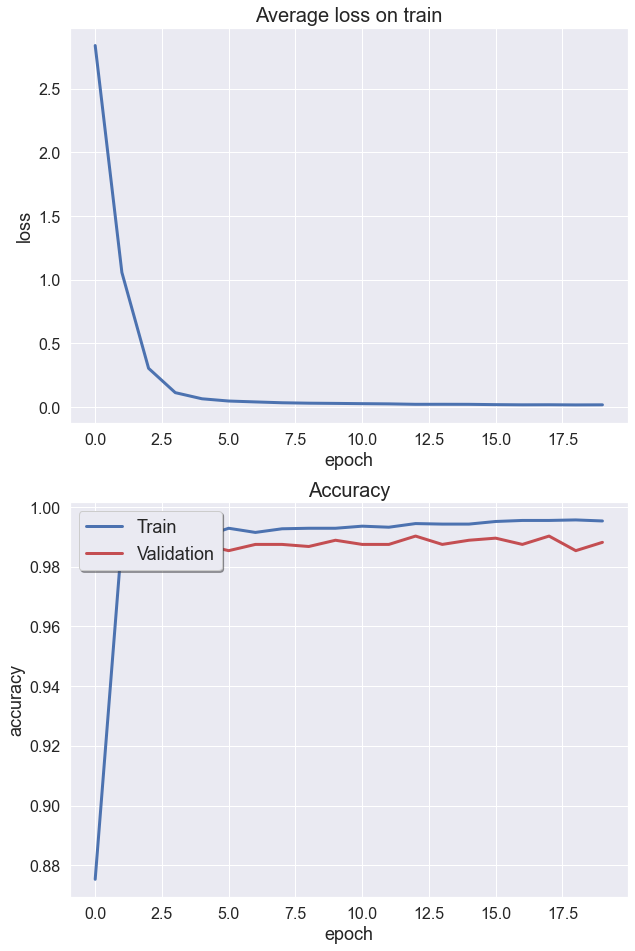

In [10]:
ConvNextL = models.convnext_large(weights="ConvNeXt_Large_Weights.IMAGENET1K_V1")

try:
    del CNl_transfer
except:
    pass
torch.cuda.empty_cache()

CNl_transfer = ConvNextL

for param in CNl_transfer.parameters():
    param.requires_grad = False
    
num_features = CNl_transfer.classifier[2].in_features
CNl_transfer.classifier[2] = nn.Linear(num_features, 50)

CNl_transfer = CNl_transfer.to(device)

parameters_CNl_transfer = CNl_transfer.classifier[2].parameters()  

loss_CNl_transfer = nn.CrossEntropyLoss()

optimizer_CNl_transfer = optim.Adam(parameters_CNl_transfer, betas=(0.9, 0.95),
                       lr=3e-4, weight_decay=1e-5)

scheduler_CNl_transfer = CosineDecayWithWarmUpScheduler(optimizer_CNl_transfer, 
                    max_lr=3e-4, min_lr=3e-6, num_step_down=20, 
                    num_step_up=0, gamma=0.5, alpha=0.3)


loss_history_CNl_transfer, train_history_CNl_transfer, val_history_CNl_transfer = train_model(CNl_transfer, train_loader, 
                                            val_loader, loss_CNl_transfer, 
                                            optimizer_CNl_transfer, 20)
plot_results(loss_history_CNl_transfer, train_history_CNl_transfer, val_history_CNl_transfer)

#### ConvNext_large with dropout and unfreezed last convolution block

Epoch 1/20
Average loss: 2.366935, Train accuracy: 0.866911, Val accuracy: 0.987439
---------------------------------------------------------------------------
Epoch 2/20
Average loss: 0.669561, Train accuracy: 0.989709, Val accuracy: 0.988835
---------------------------------------------------------------------------
Epoch 3/20
Average loss: 0.272194, Train accuracy: 0.990232, Val accuracy: 0.988137
---------------------------------------------------------------------------
Epoch 4/20
Average loss: 0.122854, Train accuracy: 0.988662, Val accuracy: 0.985345
---------------------------------------------------------------------------
Epoch 5/20
Average loss: 0.073818, Train accuracy: 0.989185, Val accuracy: 0.985345
---------------------------------------------------------------------------
Epoch 6/20
Average loss: 0.048791, Train accuracy: 0.993023, Val accuracy: 0.988835
---------------------------------------------------------------------------
Epoch 7/20
Average loss: 0.040091, Train

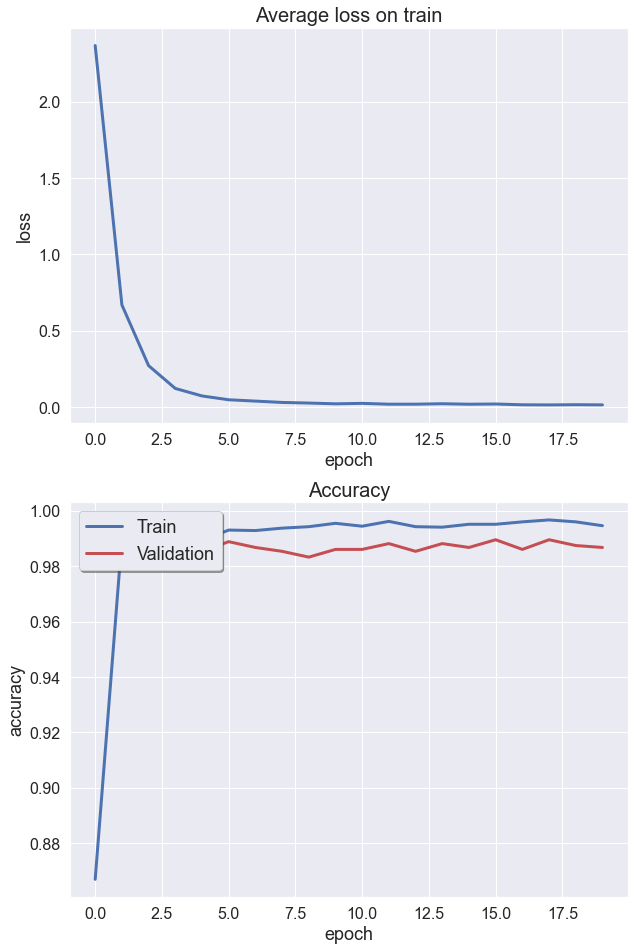

In [10]:
from itertools import chain

ConvNextL = models.convnext_large(weights="ConvNeXt_Large_Weights.IMAGENET1K_V1")

try:
    del CNl_dropout
except:
    pass
torch.cuda.empty_cache()

CNl_dropout = ConvNextL

for param in CNl_dropout.parameters():
    param.requires_grad = False
    
for param in CNl_dropout.features[-1][-1].parameters(): 
    param.requires_grad = True
    
num_features = CNl_dropout.classifier[2].in_features
CNl_dropout.classifier[2] = nn.Sequential(
                            nn.Dropout(p=0.1),
                            nn.Linear(num_features, 50))

CNl_dropout = CNl_dropout.to(device)

parameters_CNl_dropout = chain(CNl_dropout.features[-1][-1].parameters(),
                            CNl_dropout.classifier[2][1].parameters())
                               

loss_CNl_dropout = nn.CrossEntropyLoss()

optimizer_CNl_dropout = optim.Adam(parameters_CNl_dropout, betas=(0.9, 0.95),
                       lr=3e-4, weight_decay=1e-5)

scheduler_CNl_dropout = CosineDecayWithWarmUpScheduler(optimizer_CNl_dropout, 
                    max_lr=3e-4, min_lr=3e-6, num_step_down=20, 
                    num_step_up=0, gamma=0.5, alpha=0.3)


loss_history_CNl_dropout, train_history_CNl_dropout, val_history_CNl_dropout = train_model(CNl_dropout, train_loader, 
                                            val_loader, loss_CNl_dropout, 
                                            optimizer_CNl_dropout, 20)
plot_results(loss_history_CNl_dropout, train_history_CNl_dropout, val_history_CNl_dropout)

#### ConvNext_large with unfreezed last convolution block

Epoch 1/20
Average loss: 2.327063, Train accuracy: 0.875632, Val accuracy: 0.986741
---------------------------------------------------------------------------
Epoch 2/20
Average loss: 0.636016, Train accuracy: 0.989709, Val accuracy: 0.986741
---------------------------------------------------------------------------
Epoch 3/20
Average loss: 0.254355, Train accuracy: 0.990406, Val accuracy: 0.988137
---------------------------------------------------------------------------
Epoch 4/20
Average loss: 0.115130, Train accuracy: 0.990581, Val accuracy: 0.984648
---------------------------------------------------------------------------
Epoch 5/20
Average loss: 0.069052, Train accuracy: 0.991453, Val accuracy: 0.986741
---------------------------------------------------------------------------
Epoch 6/20
Average loss: 0.045679, Train accuracy: 0.992500, Val accuracy: 0.986043
---------------------------------------------------------------------------
Epoch 7/20
Average loss: 0.037781, Train

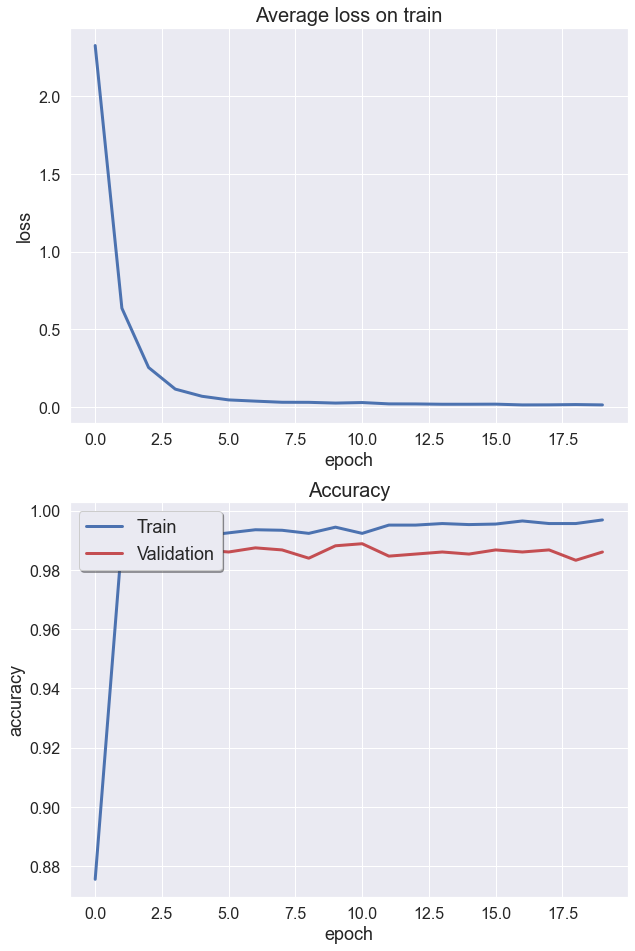

In [36]:
ConvNextL = models.convnext_large(weights="ConvNeXt_Large_Weights.IMAGENET1K_V1")

try:
    del CNl_unfr
except:
    pass
torch.cuda.empty_cache()

CNl_unfr = ConvNextL

for param in CNl_unfr.parameters():
    param.requires_grad = False
    
for param in CNl_unfr.features[-1][-1].parameters(): 
    param.requires_grad = True
    
num_features = CNl_unfr.classifier[2].in_features
CNl_unfr.classifier[2] = nn.Linear(num_features, 50)

CNl_unfr = CNl_unfr.to(device)

parameters_CNl_unfr = chain(CNl_unfr.features[-1][-1].parameters(),
                            CNl_unfr.classifier[2].parameters())
                               

loss_CNl_unfr = nn.CrossEntropyLoss()

optimizer_CNl_unfr = optim.Adam(parameters_CNl_unfr, betas=(0.9, 0.95),
                       lr=3e-4, weight_decay=1e-5)

scheduler_CNl_unfr = CosineDecayWithWarmUpScheduler(optimizer_CNl_unfr, 
                    max_lr=3e-4, min_lr=3e-6, num_step_down=20, 
                    num_step_up=0, gamma=0.5, alpha=0.3)


loss_history_CNl_unfr, train_history_CNl_unfr, val_history_CNl_unfr = train_model(CNl_unfr, train_loader, 
                                            val_loader, loss_CNl_unfr, 
                                            optimizer_CNl_unfr, 20)
plot_results(loss_history_CNl_unfr, train_history_CNl_unfr, val_history_CNl_unfr)

#### Last modifications barely changes great result achieved before and any further improvements are likely to reqiure higher computing power than I have, that's why will just stop here and hope that's enough.

#### Predictions using the best model found:

In [39]:
best_model = CNl_dropout
img_ids = []
predictions = []
best_model.eval()
for img, img_id in test_loader:
    img_ids.append(img_id)
    predictions.append(torch.argmax(best_model(img.cuda()), dim=1).item())

In [40]:
#run this to make .scv with predictions on test
import csv
rows = [[img_ids[i][0], str(predictions[i])] for i in range(len(predictions))]
rows = sorted(rows, key=lambda elem: int(elem[0].split(".")[0]))
with open("dogs_ans.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)